In [116]:
%matplotlib inline

In [117]:
import pandas as pd
from sklearn import linear_model, cross_validation
import pylab as plt
import numpy as np
pd.set_option("precision", 2)

In [118]:
def plot_correlations(data, min_match=20, size_tuple=(15,15)):
    """Plot the correlations between every variable of the data
    
    Input : pandas data frame with code, year as index and sorted
    in this order
    
    Output : graph of correlations
    """
    correlations = data.corr(min_periods=min_match)
    fig = plt.figure(figsize=size_tuple)
    norm = plt.cm.colors.Normalize(vmax=1, vmin=-1)
    plt.imshow(correlations, interpolation='nearest', norm=norm)
    plt.xticks(range(0, len(data.columns)), data.columns, rotation='vertical')
    plt.yticks(range(0, len(data.columns)), data.columns, rotation='horizontal')
    plt.colorbar()

## Importing the data

In [119]:
data = pd.read_csv("forbes_dataset.csv", index_col=['code', 'year'])
print data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 209 entries, (AUS, 1975.0) to (VEN, 1985.0)
Data columns (total 6 columns):
gini           209 non-null float64
PPPI           209 non-null float64
sch_male       209 non-null float64
sch_female     209 non-null float64
log(GNI_PC)    209 non-null float64
growth         209 non-null float64
dtypes: float64(6)
memory usage: 11.4+ KB
None


## Scatter plot

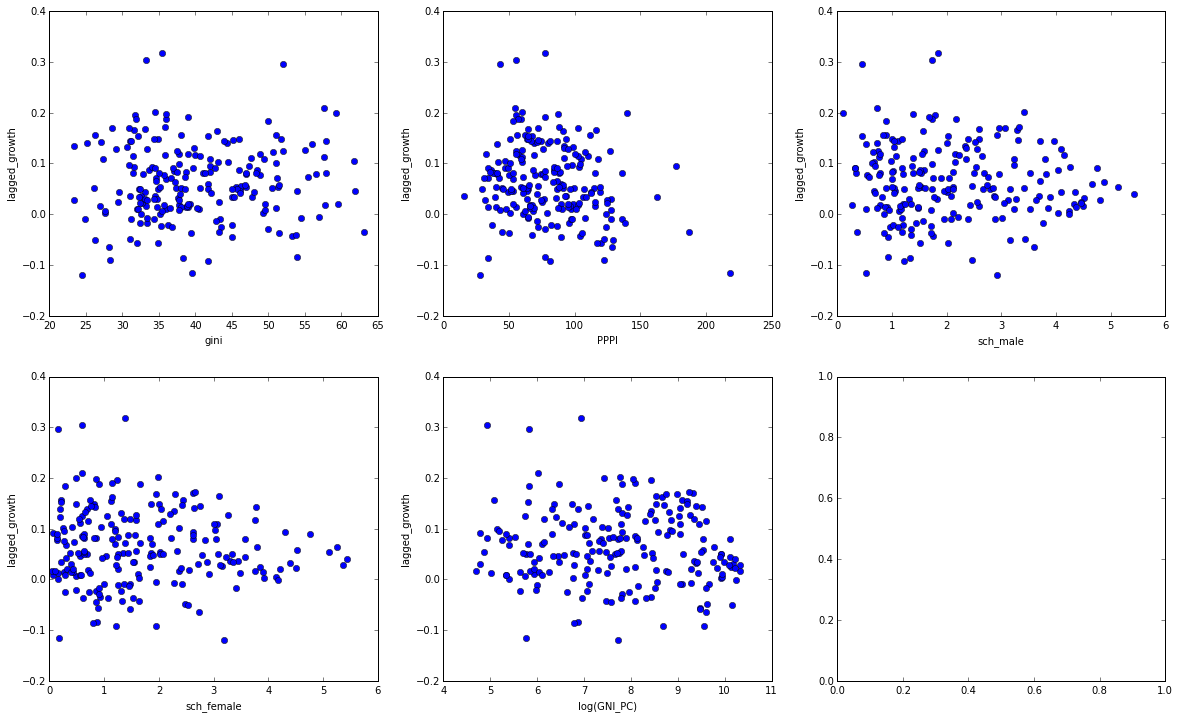

In [120]:
f, axarr = plt.subplots(2, 3, figsize=(20,12))
for n, var in enumerate(['gini', 'PPPI', 'sch_male', 'sch_female', 'log(GNI_PC)']):
    i,j = n/3, n%3
    axarr[i, j].plot(data[var], data['growth'], 'o')
    axarr[i, j].set_xlabel(var)
    axarr[i, j].set_ylabel('lagged_growth')
    # axarr[i, j].set_title(var)

## Adding one dummy per country + one per period

In [149]:
for country in sorted(np.unique(data.index.levels[0])):
    data.loc[:, country] = (data.reset_index()['code'] == country).astype(int).values
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values

## Normalize the data

In [150]:
data = (data - data.mean(axis=0)) / data.std(axis=0)

## Define the variables

In [151]:
variables = data.keys().tolist()[:4] + ['log(GNI_PC)']
dummies = data.keys().tolist()[7:]

## Select the variables

In [152]:
X = data[variables + dummies]
X_dum = data[dummies]
X_var = data[variables]
Y = data['growth']

## Linear regression

Original variance of the sample :  1.0
Variance of the residu : 0.268289556386
Explained variance share :  0.731710443614
Gini coefficient :  0.611328183398
estimation of the gini importance :  1.16067415373e-14


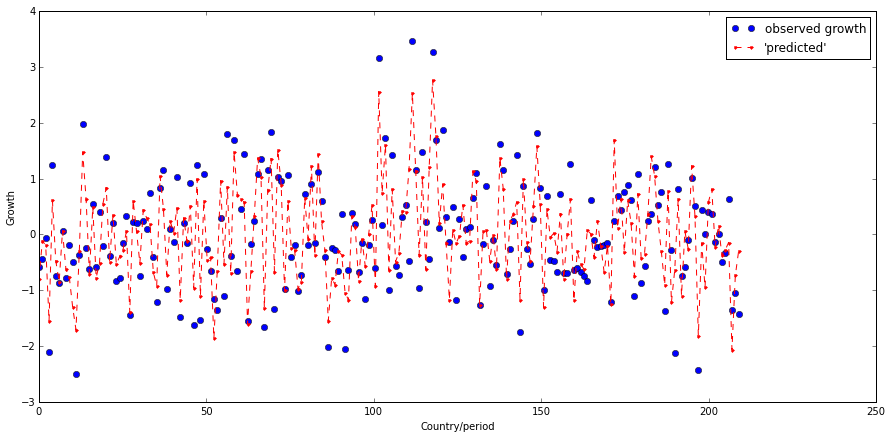

In [125]:
clf = linear_model.LinearRegression()
clf.fit(X, Y)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X.keys(), data=clf.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", clf.coef_[0] / np.absolute(clf.coef_).sum()

## Same linear regression in two steps

Growth variance :  1.0
Variance of the residu : 0.438594301687
Explained variance share :  0.561405698313


Variance of the residu :  0.438594301687
Variance of the new residu (of the regression on the residu) : 0.422624805161
Explained variance share :  0.0159694965265
Gini coefficient :  0.0506778196968
estimation of the gini importance :  0.00306082951376


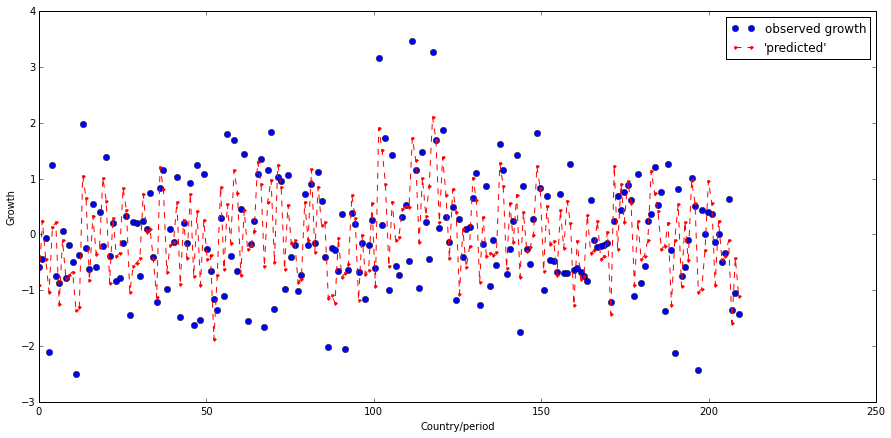

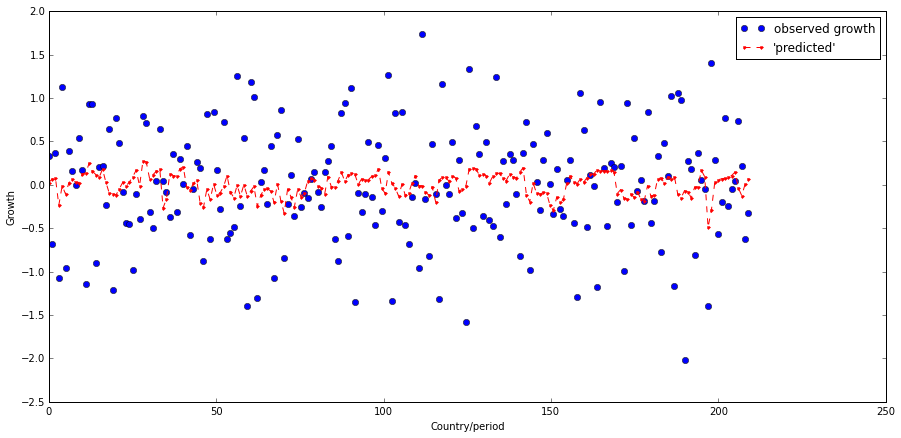

In [126]:
# Only with dummy variables
clf_dum = linear_model.LinearRegression()
clf_dum.fit (X_dum, Y)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf_dum.predict(X_dum), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Growth variance : ", Y.var()
print "Variance of the residu :", (Y - clf_dum.predict(X_dum)).var()
print "Explained variance share : ", (Y.var() - (Y - clf_dum.predict(X_dum)).var()) / Y.var()
print '\n'

# Only with non dummy variables
clf_var = linear_model.LinearRegression()
Y_res = Y - clf_dum.predict(X_dum)
clf_var.fit (X_var, Y_res)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y_res, 'o', label="observed growth")
plt.plot(x, clf_var.predict(X_var), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Variance of the residu : ", Y_res.var()
print "Variance of the new residu (of the regression on the residu) :", (Y_res - clf_var.predict(X_var)).var()
print "Explained variance share : ", (Y_res.var() - (Y_res - clf_var.predict(X_var)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X_var.keys(), data=clf_var.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", (clf_var.coef_[0] / np.absolute(clf_var.coef_).sum() * 
                                               (Y_res.var() - (Y_res - clf_var.predict(X_var)).var()) / Y.var())

## Same thing the other way around

Growth variance :  1.0
Variance of the residu : 0.950006182843
Explained variance share :  0.0499938171574
Gini coefficient :  0.011373866649
estimation of the gini importance :  0.0158046766031


Variance of the residu :  0.950006182843
Variance of the new residu (of the regression on the residu) : 0.402592273008
Explained variance share :  0.547413909835


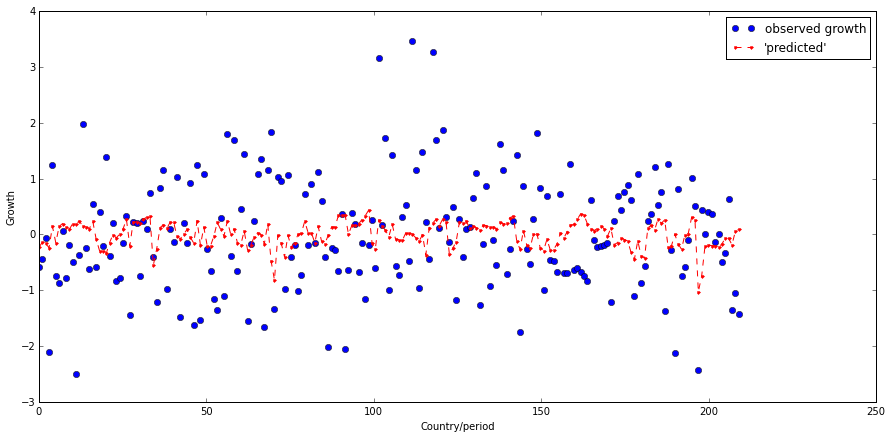

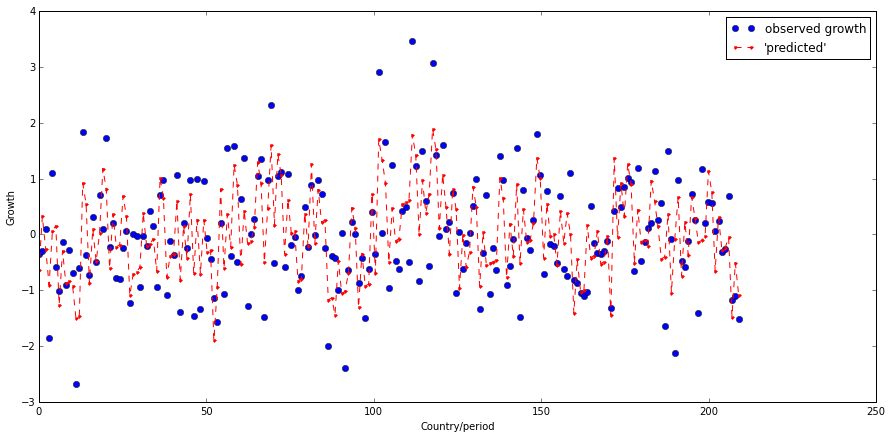

In [127]:
# Only with non-dummy variables
clf_var = linear_model.LinearRegression()
clf_var.fit (X_var, Y)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf_var.predict(X_var), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Growth variance : ", Y.var()
print "Variance of the residu :", (Y - clf_var.predict(X_var)).var()
print "Explained variance share : ", (Y.var() - (Y - clf_var.predict(X_var)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X_var.keys(), data=clf_var.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", np.absolute(clf_var.coef_[0]) / np.absolute(clf_var.coef_).sum()
print '\n'
                                               
# Only with dummy variables
clf_dum = linear_model.LinearRegression()
Y_res = Y - clf_var.predict(X_var)
clf_dum.fit(X_dum, Y_res)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y_res, 'o', label="observed growth")
plt.plot(x, clf_dum.predict(X_dum), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Variance of the residu : ", Y_res.var()
print "Variance of the new residu (of the regression on the residu) :", (Y_res - clf_dum.predict(X_dum)).var()
print "Explained variance share : ", (Y_res.var() - (Y_res - clf_dum.predict(X_dum)).var()) / Y.var()

## Trying to explain all this

In [128]:
data['stand_growth'] = Y - Y.groupby(level=0).mean()

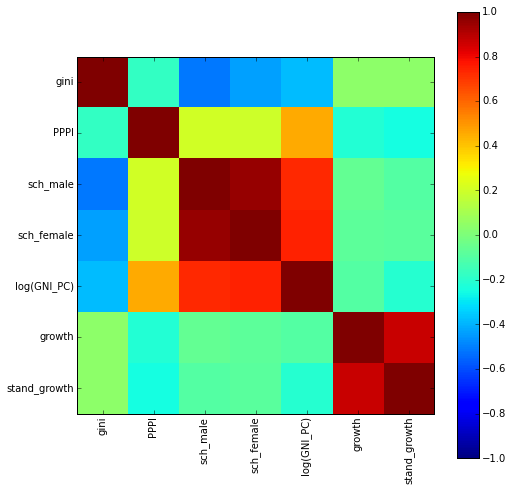

In [129]:
plot_correlations(data[variables + ['growth', "stand_growth"]], size_tuple=(8,8))

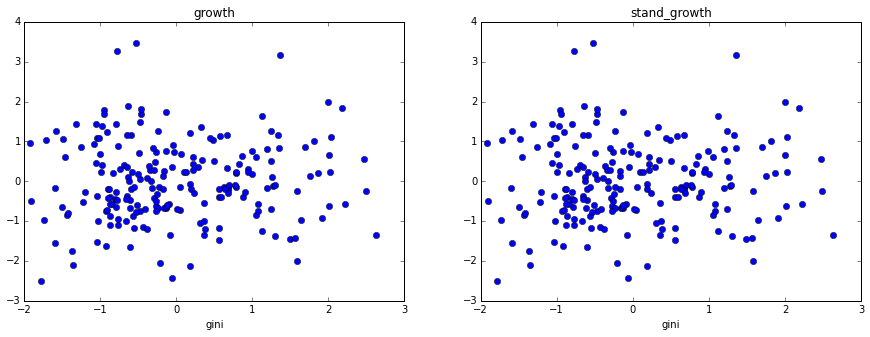

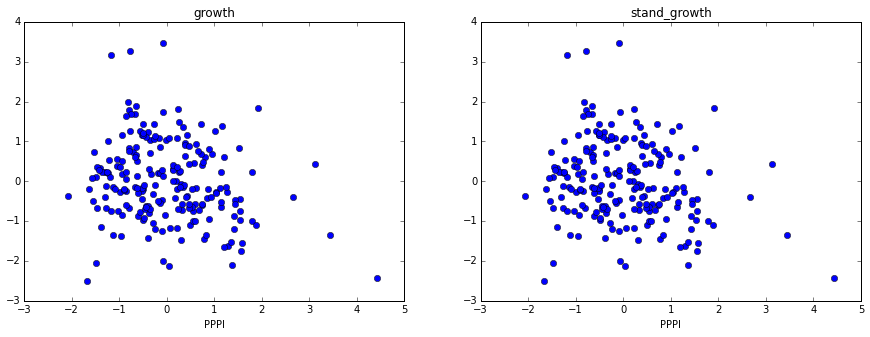

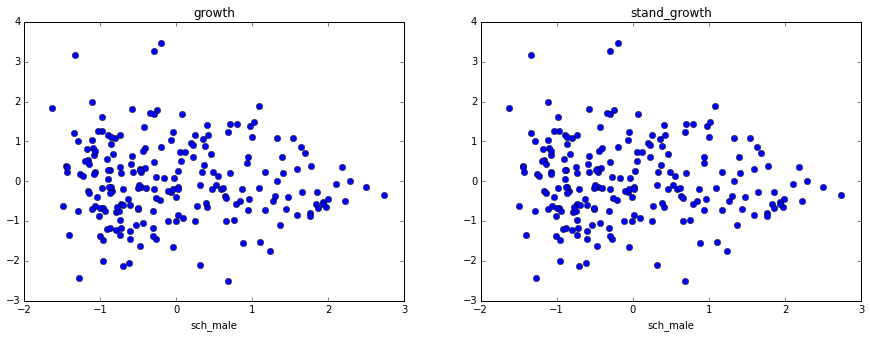

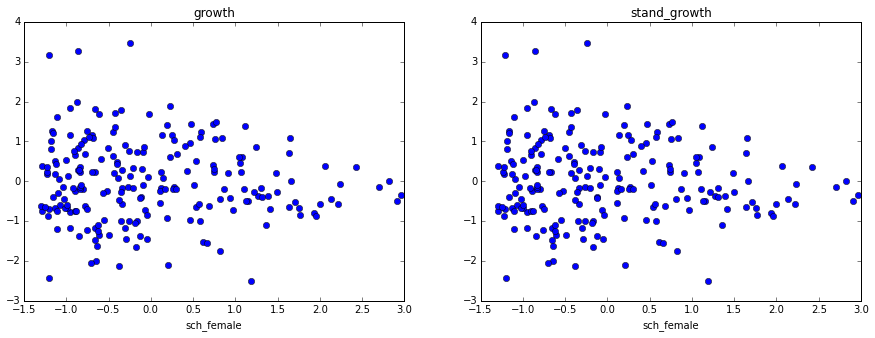

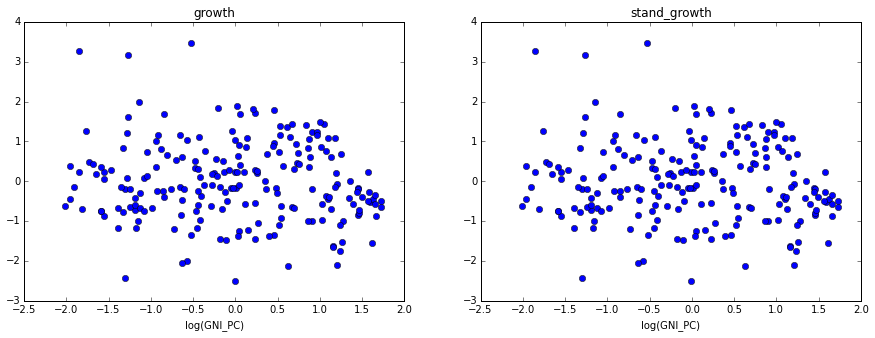

In [130]:
for var in variables:
    f, axarr = plt.subplots(1, 2, figsize=(15, 5))
    axarr[0].set_xlabel(var)    
    axarr[0].plot(data[var], Y, 'o')
    axarr[0].set_title('growth')
    axarr[1].set_xlabel(var)    
    axarr[1].plot(data[var], Y, 'o')
    axarr[1].set_title('stand_growth')

In [131]:
for var in variables + ['growth']:
    print "Mean standard deviation of the " + var + " within a country : ", data[var].groupby(level=0).std().mean()
    print "Expected value", np.mean([np.random.choice(data[var], k).std() 
                                     for k in data[var].groupby(level=0).size().tolist() * 200])
    print '\n'

Mean standard deviation of the gini within a country :  0.285206053126
Expected value 0.749429392192


Mean standard deviation of the PPPI within a country :  0.529907961777
Expected value 0.742439339236


Mean standard deviation of the sch_male within a country :  0.318107285407
Expected value 0.746692621806


Mean standard deviation of the sch_female within a country :  0.2964974683
Expected value 0.740206664193


Mean standard deviation of the log(GNI_PC) within a country :  0.360539173376
Expected value 0.763980391307


Mean standard deviation of the growth within a country :  0.926862722733
Expected value 0.743858800802




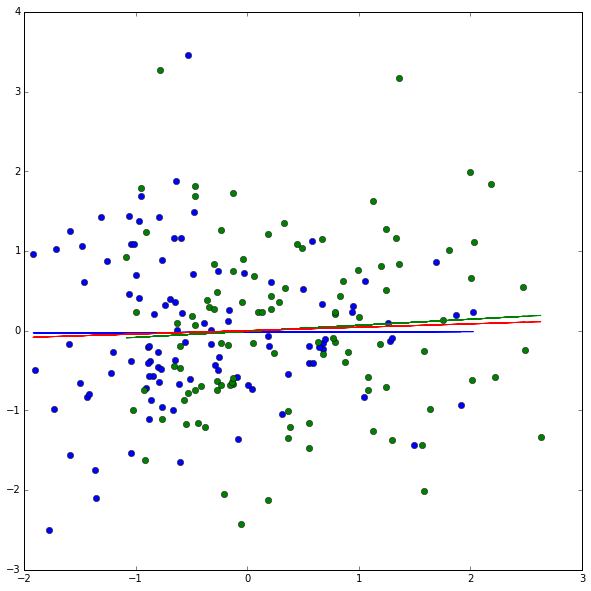

In [132]:
high_school = data[data['sch_female'] > data['sch_female'].median()]
low_school = data[data['sch_female'] <= data['sch_female'].median()]
plt.figure(figsize=(10, 10))

model = linear_model.LinearRegression()
model.fit(data['gini'].reshape((len(data),1)), data['growth'].reshape((len(data),1)))

low_model = linear_model.LinearRegression()
low_model.fit(low_school['gini'].reshape((len(low_school),1)), low_school['growth'].reshape((len(low_school),1)))

high_model = linear_model.LinearRegression()
high_model.fit(high_school['gini'].reshape((len(high_school),1)), high_school['growth'].reshape((len(high_school),1)))

plt.plot(high_school['gini'], high_school['growth'], 'bo')
plt.plot(high_school['gini'], high_model.predict(high_school['gini'].reshape((len(high_school),1))), 'b-')

plt.plot(low_school['gini'], low_school['growth'], 'go')
plt.plot(low_school['gini'], low_model.predict(low_school['gini'].reshape((len(low_school),1))), 'g-')

plt.plot(data['gini'], model.predict(data['gini'].reshape((len(data),1))), 'r-')

# Cross validating the coefficient to ensure no overfitting

Best alpha parameter :  {'alpha': 0.0091029817799152171}
Best score :  0.316449743209
Original variance of the sample :  1.0
Variance of the residu : 0.556037696321
Explained variance share :  0.443962303679


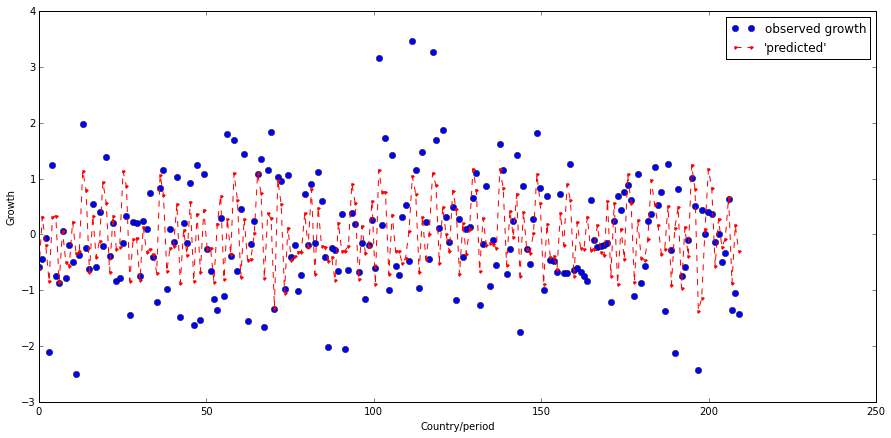

In [147]:
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=10)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

In [148]:
coefs = pd.DataFrame(index=X.keys(), data=clf.best_estimator_.coef_)
print coefs[coefs[0]!=0]

                    0
gini         7.00e-02
PPPI        -1.61e-01
sch_male     3.06e-01
sch_female  -2.46e-01
log(GNI_PC)  1.23e-01
1965         9.92e-01
1970         5.87e-01
1975        -8.58e-01
1980         9.11e-03
1985        -5.31e-01
1990        -5.61e-01


Faire un lasso en autorisant uniquement une pénalisation sur les dummies pays (en ajoutant éventuellement les pays les plus particuliers)

# Try to cross validate the sign of the gini coefficient

In [146]:
coefs = pd.DataFrame(index=X_dum.keys())
kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True)
for i, (train_index, test_index) in enumerate(kf):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_dum.values[train_index], X_dum.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]
    clf = linear_model.LinearRegression()
    clf.fit(X_train, Y_train)
    print i, "th fold"
    print "Original variance of the sample : ", Y_test.var()
    print "Variance of the residu :", (Y_test - clf.predict(X_test)).var()
    print "Explained variance share : ", (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var(), '\n'
    coefs[i] = clf.coef_
coefs['std'] = coefs.std(axis=1)
coefs['mean'] = coefs.mean(axis=1)
print coefs

0 th fold
Original variance of the sample :  1.18441309136
Variance of the residu : 1.1065168364
Explained variance share :  0.0657678098341 

1 th fold
Original variance of the sample :  0.682173103887
Variance of the residu : 1.21105354361
Explained variance share :  -0.775287733733 

2 th fold
Original variance of the sample :  1.34952557143
Variance of the residu : 0.986257761509
Explained variance share :  0.269181864805 

3 th fold
Original variance of the sample :  0.63900160912
Variance of the residu : 0.748802284325
Explained variance share :  -0.171831609871 

4 th fold
Original variance of the sample :  1.01458485251
Variance of the residu : 1.10463527481
Explained variance share :  -0.0887559301472 

             0         1         2         3         4       std      mean
BEL   2.54e+01 -6.66e+01 -1.93e+01 -1.17e+01  0.00e+00  3.37e+01 -6.41e+00
BGD   3.59e+01 -9.37e+01 -3.54e+01 -4.91e+01 -2.98e+01  4.66e+01 -2.09e+01
BGR  -1.91e+00 -1.47e+02 -1.58e+02 -1.01e+02 -8.61e+0